### Hands on tutorial of Graph Representation Learning

In this lecture, we will go through the following topics
1. Graph structued data in Python
2. GNN package - Pytorch-Geometric introduction
3. Representation in Graphs - node2vec, GCN
4. GNN with downstrean tasks
5. GNN for text classification


In [1]:
import os
import torch
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

from torch_geometric.nn import Node2Vec
import torch_cluster
import os.path as osp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from tqdm.notebook import tqdm
random_walk = torch.ops.torch_cluster.random_walk

2.2.1


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

if torch.cuda.is_available():
    print("CUDA is available. CUDA version:", torch.version.cuda)
else:
    print("CUDA is not available.")

CUDA is available.
CUDA is available. CUDA version: 12.1


# Graph Representation Learning
The goal of Graph Representation Learning aims at learning **embedding vectors** for each node that preserves the proximity in graphs. <br>
To demonstrate, we make use of the `KarateClud` dataset, as we introduced before.

![](https://i.imgur.com/oQv59aR.png)

In [3]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
model = Node2Vec(data.edge_index, embedding_dim=16, 
                 walk_length=10,                        # lenght of rw
                 context_size=10, walks_per_node=80,
                 num_negative_samples=1,
                 p=4,q=1,
                 sparse=True)

In [5]:
loader = model.loader(batch_size=128, shuffle=True)

In [6]:
for idx, (pos_nodes, neg_nodes) in enumerate(loader):
    print(idx, pos_nodes.shape, neg_nodes.shape)

0 torch.Size([2720, 10]) torch.Size([2720, 10])


In [7]:
print(pos_nodes)

tensor([[ 4,  6,  0,  ..., 32,  2,  7],
        [16,  5,  6,  ..., 10,  4, 10],
        [19, 33, 18,  ..., 26, 33,  8],
        ...,
        [28, 33, 29,  ..., 28, 33,  8],
        [29, 23, 27,  ..., 23, 29, 32],
        [21,  0, 17,  ...,  1, 17,  1]])


In [8]:
print(len(pos_nodes))

2720


In [9]:
print(neg_nodes)

tensor([[ 4, 33, 20,  ...,  6,  0, 10],
        [16, 17, 21,  ..., 32, 28, 26],
        [19, 10, 21,  ...,  5, 32, 16],
        ...,
        [28,  0, 32,  ..., 15,  2, 14],
        [29, 29,  9,  ..., 14,  2, 22],
        [21, 19,  0,  ..., 11, 24,  4]])


## Visualization

In [10]:
import networkx as nx 
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

In [11]:
print([tuple(x) for x in data.edge_index.numpy().transpose()])
print(G)
neighbors={}
for edge in edge_tuples:
    src=edge[0]
    dst=edge[1]
    if src not in neighbors:
        neighbors[src]=[dst]
    else:
        neighbors[src].append(dst)
cnt=0
for node in neighbors:
    print(f"node = {node}")
    print(f"There are {len(neighbors[node])} neighbors of node {node}")
    cnt+=len(neighbors[node])
    print(f"{neighbors[node]}")
print(cnt)
print(pos)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 0), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 0), (2, 1), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 0), (3, 1), (3, 2), (3, 7), (3, 12), (3, 13), (4, 0), (4, 6), (4, 10), (5, 0), (5, 6), (5, 10), (5, 16), (6, 0), (6, 4), (6, 5), (6, 16), (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (8, 30), (8, 32), (8, 33), (9, 2), (9, 33), (10, 0), (10, 4), (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (16, 5), (16, 6), (17, 0), (17, 1), (18, 32), (18, 33), (19, 0), (19, 1), (19, 33), (20, 32), (20, 33), (21, 0), (21, 1), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 23), (25, 24), (25, 31), (26, 29), (26, 33), (27, 2), (27, 23), (27, 24), (27, 33), (28, 2), (28, 31)

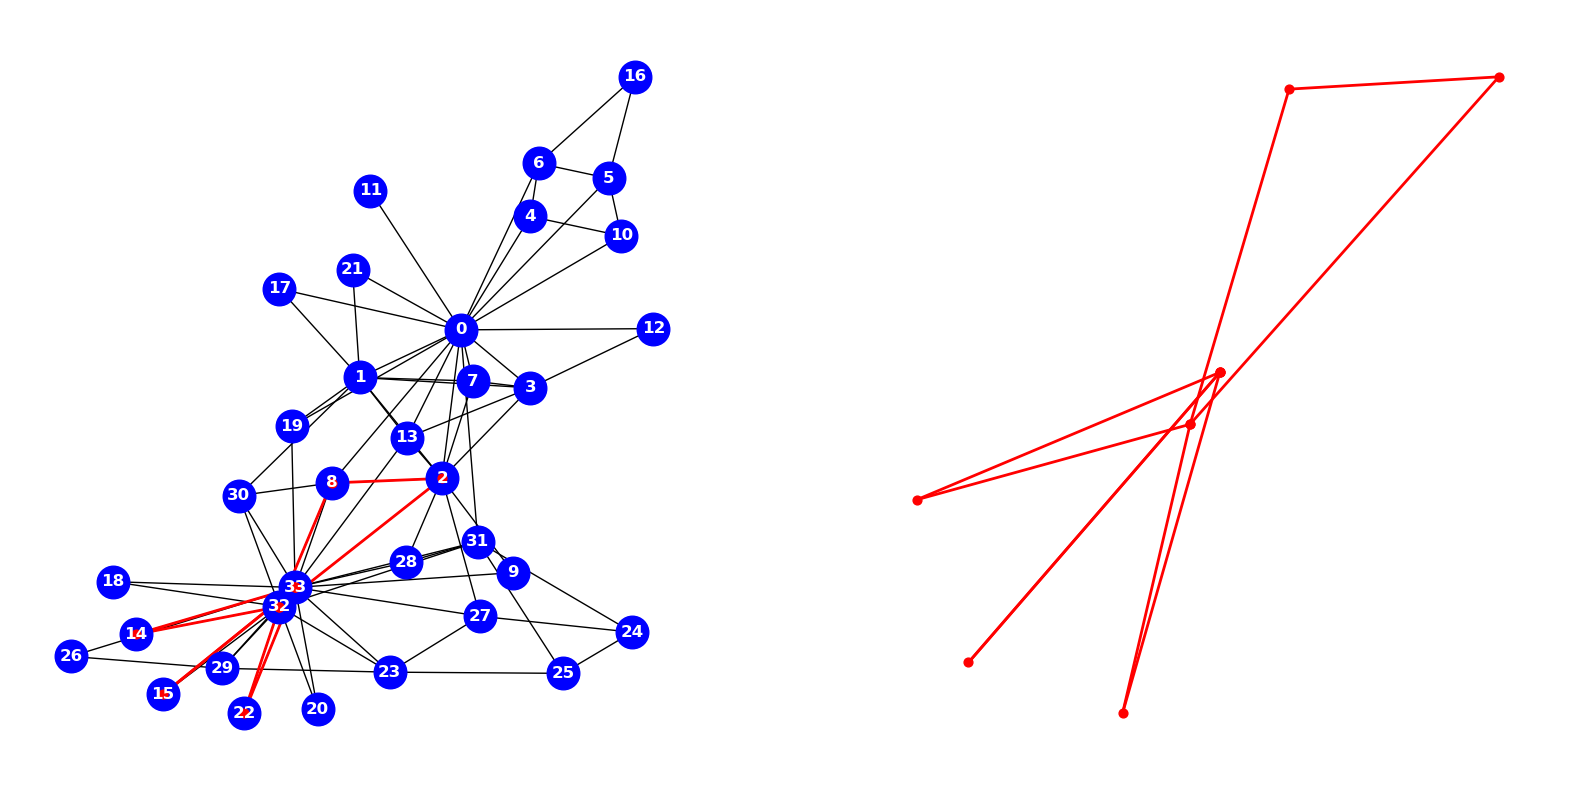

In [13]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx(G, 
   ax=ax,
   pos=nx.get_node_attributes(G, 'pos'), 
   node_size=550,
   node_color='b',
   font_color="white",
   font_weight='bold'
                )
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 


In [14]:
# print(next(enumerate(loader)))
# print(next(enumerate(loader))[1])
print("----------------------------------------\n\n\n")
print(len(next(enumerate(loader))[1][0]))
print(next(enumerate(loader))[1][0][0])

----------------------------------------



2720
tensor([33, 13,  3,  2, 13,  0, 17,  1, 17,  0])


## Training
Let's create a `Node2vec` model from the `PyG` libiary, which provides the dataloader for creating training instances as well as calculating the objective function. <br>
The objective function is defined as follows

\begin{equation}
L(\Theta) = \log \left ( \sigma (z_u^{\top} z_v)  \right) - \sum_{i=1}^k \log \left ( \sigma (z_u^{\top} z_{n_i})  \right), n_i \sim P_V
\end{equation}

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(data.edge_index)
node2vec_model = Node2Vec(data.edge_index, embedding_dim=2, walk_length=10,
                 context_size=4, walks_per_node=80,
                 num_negative_samples=5, p=4, q=1, sparse=True).to(device)
print(node2vec_model)
loader = node2vec_model.loader(batch_size=128, shuffle=True)
print(loader)
optimizer = torch.optim.SparseAdam(list(node2vec_model.parameters()), lr=0.01)
print(optimizer)

cuda
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  

In [19]:
def train():
    node2vec_model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = node2vec_model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [20]:
for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01, Loss: 1.7128


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02, Loss: 1.7134


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03, Loss: 1.7037


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04, Loss: 1.6944


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05, Loss: 1.6780


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06, Loss: 1.6729


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07, Loss: 1.6658


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08, Loss: 1.6571


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.6444


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.6390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.6296


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Loss: 1.6110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Loss: 1.6142


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Loss: 1.6061


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Loss: 1.5964


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, Loss: 1.5870


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, Loss: 1.5895


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, Loss: 1.5701


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, Loss: 1.5652


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20, Loss: 1.5573


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21, Loss: 1.5560


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22, Loss: 1.5395


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23, Loss: 1.5367


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24, Loss: 1.5371


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25, Loss: 1.5272


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26, Loss: 1.5211


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27, Loss: 1.5103


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28, Loss: 1.5068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29, Loss: 1.5045


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30, Loss: 1.4974


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 31, Loss: 1.4965


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 32, Loss: 1.4936


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 33, Loss: 1.4902


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 34, Loss: 1.4832


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 35, Loss: 1.4721


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 36, Loss: 1.4713


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 37, Loss: 1.4689


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 38, Loss: 1.4681


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 39, Loss: 1.4606


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 40, Loss: 1.4512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41, Loss: 1.4539


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42, Loss: 1.4532


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43, Loss: 1.4452


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44, Loss: 1.4426


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45, Loss: 1.4411


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46, Loss: 1.4302


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47, Loss: 1.4272


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48, Loss: 1.4276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 49, Loss: 1.4287


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 50, Loss: 1.4216


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 51, Loss: 1.4133


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 52, Loss: 1.4154


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 53, Loss: 1.4054


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 54, Loss: 1.4077


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 55, Loss: 1.4025


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 56, Loss: 1.4040


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 57, Loss: 1.3934


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 58, Loss: 1.3954


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 59, Loss: 1.3945


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 60, Loss: 1.3888


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 61, Loss: 1.3869


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 62, Loss: 1.3875


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 63, Loss: 1.3834


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 64, Loss: 1.3744


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 65, Loss: 1.3763


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 66, Loss: 1.3737


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 67, Loss: 1.3705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 68, Loss: 1.3646


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 69, Loss: 1.3637


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 70, Loss: 1.3638


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 71, Loss: 1.3649


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 72, Loss: 1.3599


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 73, Loss: 1.3524


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 74, Loss: 1.3518


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 75, Loss: 1.3546


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 76, Loss: 1.3480


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 77, Loss: 1.3482


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 78, Loss: 1.3477


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 79, Loss: 1.3423


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 80, Loss: 1.3425


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 81, Loss: 1.3410


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 82, Loss: 1.3395


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 83, Loss: 1.3298


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 84, Loss: 1.3279


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 85, Loss: 1.3334


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 86, Loss: 1.3267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 87, Loss: 1.3281


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 88, Loss: 1.3185


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 89, Loss: 1.3233


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 90, Loss: 1.3227


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 91, Loss: 1.3181


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 92, Loss: 1.3176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 93, Loss: 1.3166


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 94, Loss: 1.3144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 95, Loss: 1.3116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 96, Loss: 1.3080


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 97, Loss: 1.3107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 98, Loss: 1.3066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 99, Loss: 1.3025


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 100, Loss: 1.3051


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 101, Loss: 1.2991


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 102, Loss: 1.3027


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 103, Loss: 1.2961


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 104, Loss: 1.2949


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 105, Loss: 1.2915


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 106, Loss: 1.2926


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 107, Loss: 1.2937


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 108, Loss: 1.2884


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 109, Loss: 1.2852


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 110, Loss: 1.2845


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 111, Loss: 1.2859


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 112, Loss: 1.2854


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 113, Loss: 1.2818


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 114, Loss: 1.2806


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 115, Loss: 1.2760


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 116, Loss: 1.2782


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 117, Loss: 1.2777


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 118, Loss: 1.2785


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 119, Loss: 1.2692


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 120, Loss: 1.2732


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 121, Loss: 1.2675


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 122, Loss: 1.2699


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 123, Loss: 1.2733


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 124, Loss: 1.2683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 125, Loss: 1.2682


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 126, Loss: 1.2659


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 127, Loss: 1.2624


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 128, Loss: 1.2611


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 129, Loss: 1.2586


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 130, Loss: 1.2603


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 131, Loss: 1.2584


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 132, Loss: 1.2561


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 133, Loss: 1.2561


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 134, Loss: 1.2510


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 135, Loss: 1.2540


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 136, Loss: 1.2523


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 137, Loss: 1.2512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 138, Loss: 1.2500


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 139, Loss: 1.2465


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 140, Loss: 1.2460


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 141, Loss: 1.2421


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 142, Loss: 1.2424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 143, Loss: 1.2462


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 144, Loss: 1.2386


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 145, Loss: 1.2397


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 146, Loss: 1.2394


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 147, Loss: 1.2371


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 148, Loss: 1.2403


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 149, Loss: 1.2383


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 150, Loss: 1.2354


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 151, Loss: 1.2337


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 152, Loss: 1.2334


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 153, Loss: 1.2350


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 154, Loss: 1.2311


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 155, Loss: 1.2291


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 156, Loss: 1.2320


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 157, Loss: 1.2262


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 158, Loss: 1.2271


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 159, Loss: 1.2246


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 160, Loss: 1.2255


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 161, Loss: 1.2250


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 162, Loss: 1.2244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 163, Loss: 1.2226


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 164, Loss: 1.2221


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 165, Loss: 1.2207


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 166, Loss: 1.2237


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 167, Loss: 1.2190


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 168, Loss: 1.2123


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 169, Loss: 1.2180


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 170, Loss: 1.2138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 171, Loss: 1.2159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 172, Loss: 1.2104


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 173, Loss: 1.2107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 174, Loss: 1.2118


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 175, Loss: 1.2074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 176, Loss: 1.2130


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 177, Loss: 1.2091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 178, Loss: 1.2108


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 179, Loss: 1.2097


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 180, Loss: 1.2084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 181, Loss: 1.2107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 182, Loss: 1.2068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 183, Loss: 1.2088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 184, Loss: 1.2067


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 185, Loss: 1.2093


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 186, Loss: 1.2063


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 187, Loss: 1.1981


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 188, Loss: 1.1988


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 189, Loss: 1.2046


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 190, Loss: 1.2013


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 191, Loss: 1.1986


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 192, Loss: 1.2009


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 193, Loss: 1.1964


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 194, Loss: 1.2018


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 195, Loss: 1.1971


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 196, Loss: 1.1943


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 197, Loss: 1.1963


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 198, Loss: 1.1948


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 199, Loss: 1.1977


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 200, Loss: 1.1937


In [21]:
# obtain labels for each nodes
G = nx.karate_club_graph()

labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# color mapping
mapping = {0:"purple",1:"green"}
node_colors = [mapping[i] for i in labels]

0
{'club': 'Mr. Hi'}

1
{'club': 'Mr. Hi'}

2
{'club': 'Mr. Hi'}

3
{'club': 'Mr. Hi'}

4
{'club': 'Mr. Hi'}

5
{'club': 'Mr. Hi'}

6
{'club': 'Mr. Hi'}

7
{'club': 'Mr. Hi'}

8
{'club': 'Mr. Hi'}

9
{'club': 'Officer'}

10
{'club': 'Mr. Hi'}

11
{'club': 'Mr. Hi'}

12
{'club': 'Mr. Hi'}

13
{'club': 'Mr. Hi'}

14
{'club': 'Officer'}

15
{'club': 'Officer'}

16
{'club': 'Mr. Hi'}

17
{'club': 'Mr. Hi'}

18
{'club': 'Officer'}

19
{'club': 'Mr. Hi'}

20
{'club': 'Officer'}

21
{'club': 'Mr. Hi'}

22
{'club': 'Officer'}

23
{'club': 'Officer'}

24
{'club': 'Officer'}

25
{'club': 'Officer'}

26
{'club': 'Officer'}

27
{'club': 'Officer'}

28
{'club': 'Officer'}

29
{'club': 'Officer'}

30
{'club': 'Officer'}

31
{'club': 'Officer'}

32
{'club': 'Officer'}

33
{'club': 'Officer'}

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'purple', 'purple', 'purple', 'purple', '

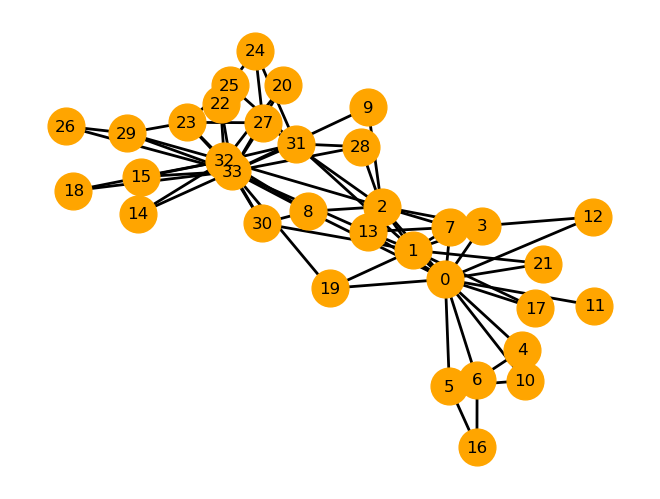

In [31]:
for node_idx in G.nodes:
    print(node_idx)
    print(G.nodes[node_idx])
    print()
nx.draw(G, with_labels = True, node_color = "orange", width=2,node_size=700)
print(labels)
print(node_colors)

In [32]:
node2vec_model(torch.arange(data.num_nodes, device=device))


tensor([[-1.2734,  0.1086],
        [-1.0208,  0.8409],
        [-0.2941,  1.1677],
        [-1.3191,  1.3563],
        [-0.5472, -0.6708],
        [-0.8259, -1.2239],
        [-0.9324, -1.1560],
        [-0.2297,  0.4280],
        [-0.2195,  0.7463],
        [ 0.1450,  0.3368],
        [ 0.3403, -1.2398],
        [-0.4503, -0.5113],
        [-0.8184, -0.2260],
        [-0.5092,  0.5918],
        [ 0.6310,  0.1510],
        [ 0.6233,  0.1927],
        [-0.4330, -1.3187],
        [-0.7532, -0.1370],
        [ 0.5243,  0.2997],
        [-0.5509,  0.6285],
        [ 0.4090,  0.3441],
        [-0.7572, -0.1139],
        [-0.0876,  0.4633],
        [ 1.1183,  0.5717],
        [ 1.2387, -0.4341],
        [ 1.1223, -0.0650],
        [-0.0607,  0.4049],
        [ 0.8706,  0.3953],
        [ 0.3388,  0.4198],
        [ 0.7306,  0.5321],
        [-0.1214,  0.7219],
        [ 0.6157,  0.9995],
        [ 0.7224,  1.4029],
        [ 0.6453,  1.7730]], device='cuda:0', grad_fn=<IndexBackward0>)

In [34]:
print(data.num_nodes)

34


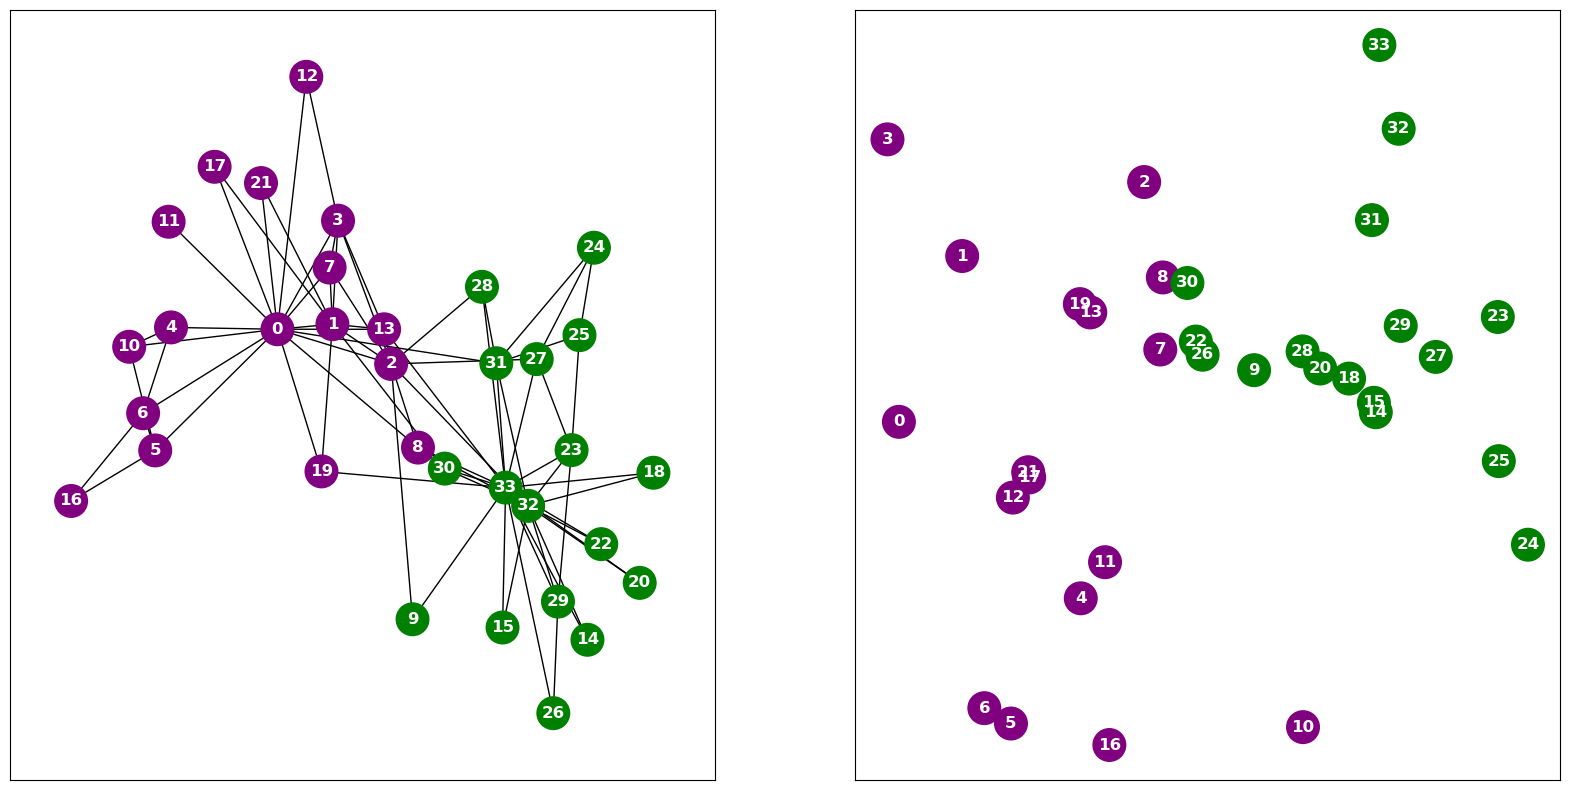

In [38]:
fig = plt.figure(figsize=(20, 10))

# plot the original graph
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx(G, 
   ax=ax,
   pos = nx.spring_layout(G, center=[0.5, 0.5]), 
   node_size=550,
   node_color=node_colors,
   font_color="white",
   font_weight='bold'
                )

# visualize embedding in 2D space
ax = fig.add_subplot(1, 2, 2)
with torch.no_grad():
    embedding = node2vec_model(torch.arange(data.num_nodes, device=device))
    embedding = embedding.cpu().numpy()
    pos = {i:v for i,v in enumerate(embedding)}

# make plots
nx.draw_networkx_nodes(G, 
   ax=ax,
   pos=pos, 
   node_size=550,
   node_color=node_colors,
)

nx.draw_networkx_labels(
    G,
    pos=pos, 
   font_color="white",
   font_weight='bold',
   )
plt.show()

# Practice: Representation learning on large graphs
<!-- This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*). -->

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).<br>

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid)

Another interesting application citation graphs could be found at [connected papers](https://www.connectedpapers.com/).

In [39]:
from torch_geometric.datasets import Planetoid

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(root=path, name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


In [48]:
print(len(data.train_mask))
print(len(data.val_mask))
print(len(data.test_mask))
dic={0:0,1:0,2:0,3:0}
for i in range(len(data.train_mask)):
    print(data.train_mask[i],data.val_mask[i],data.test_mask[i])
    summ=int(data.train_mask[i])+int(data.val_mask[i])+int(data.test_mask[i])
    dic[summ]+=1
print(dic)

2708
2708
2708
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
tensor(True) tensor(False) tensor(False)
t

Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing. We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).
<!-- Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors. -->


## Practice: learning node embeddings for each node (document)
1. Please use node2vec to learn embeddings on `Cora` dataset
2. Define your node2vec model configurations
3. Training
4. Vistualization nodes in 2D space. The color of node indicates the "label" of the node. What did you observe in the figure?

In [58]:
# initialize model
node2vec_model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = node2vec_model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec_model.parameters()), lr=0.01)

In [59]:
print(len(data.edge_index[0]))

10556


In [60]:
# training 
for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.1728


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02, Loss: 6.0966


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03, Loss: 4.9668


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.1487


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 05, Loss: 3.4879


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 06, Loss: 2.9700


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 07, Loss: 2.5616


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 08, Loss: 2.2275


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.9616


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.7495


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.5730


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 12, Loss: 1.4369


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 13, Loss: 1.3257


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 14, Loss: 1.2381


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 15, Loss: 1.1684


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 16, Loss: 1.1094


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 17, Loss: 1.0661


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 18, Loss: 1.0276


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.9995


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.9753


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.9540


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.9402


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.9249


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.9149


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.9036


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.8961


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.8896


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.8834


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.8758


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.8723


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.8664


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.8638


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.8601


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.8583


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.8550


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.8531


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.8511


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.8486


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.8473


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.8447


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.8433


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.8425


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.8397


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.8408


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.8383


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.8390


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.8374


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.8361


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.8347


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.8348


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.8345


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.8335


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.8326


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.8330


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.8316


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.8301


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.8307


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.8312


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.8292


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.8295


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.8299


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.8292


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.8290


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.8284


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.8286


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.8281


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.8277


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.8280


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.8265


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.8267


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.8268


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.8264


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.8256


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.8271


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.8260


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.8272


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.8258


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.8261


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.8262


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.8258


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.8260


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.8262


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.8254


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.8245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.8257


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.8252


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.8244


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.8251


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.8250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.8244


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.8257


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.8247


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.8232


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.8251


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.8245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.8250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.8248


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.8252


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 100, Loss: 0.8251


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 101, Loss: 0.8236


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 102, Loss: 0.8237


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 103, Loss: 0.8240


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 104, Loss: 0.8233


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 105, Loss: 0.8235


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 106, Loss: 0.8251


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 107, Loss: 0.8252


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 108, Loss: 0.8241


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 109, Loss: 0.8241


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 110, Loss: 0.8250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 111, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 112, Loss: 0.8251


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 113, Loss: 0.8234


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 114, Loss: 0.8241


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 115, Loss: 0.8243


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 116, Loss: 0.8249


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 117, Loss: 0.8236


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 118, Loss: 0.8243


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 119, Loss: 0.8241


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 120, Loss: 0.8253


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 121, Loss: 0.8237


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 122, Loss: 0.8233


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 123, Loss: 0.8241


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 124, Loss: 0.8235


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 125, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 126, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 127, Loss: 0.8231


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 128, Loss: 0.8240


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 129, Loss: 0.8250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 130, Loss: 0.8239


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 131, Loss: 0.8259


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 132, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 133, Loss: 0.8245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 134, Loss: 0.8242


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 135, Loss: 0.8237


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 136, Loss: 0.8251


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 137, Loss: 0.8233


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 138, Loss: 0.8248


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 139, Loss: 0.8252


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 140, Loss: 0.8234


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 141, Loss: 0.8239


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 142, Loss: 0.8239


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 143, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 144, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 145, Loss: 0.8225


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 146, Loss: 0.8244


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 147, Loss: 0.8239


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 148, Loss: 0.8244


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 149, Loss: 0.8250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 150, Loss: 0.8247


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 151, Loss: 0.8243


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 152, Loss: 0.8247


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 153, Loss: 0.8241


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 154, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 155, Loss: 0.8239


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 156, Loss: 0.8243


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 157, Loss: 0.8244


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 158, Loss: 0.8249


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 159, Loss: 0.8245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 160, Loss: 0.8248


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 161, Loss: 0.8237


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 162, Loss: 0.8242


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 163, Loss: 0.8247


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 164, Loss: 0.8247


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 165, Loss: 0.8252


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 166, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 167, Loss: 0.8239


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 168, Loss: 0.8249


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 169, Loss: 0.8250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 170, Loss: 0.8243


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 171, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 172, Loss: 0.8245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 173, Loss: 0.8229


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 174, Loss: 0.8233


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 175, Loss: 0.8248


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 176, Loss: 0.8245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 177, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 178, Loss: 0.8251


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 179, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 180, Loss: 0.8247


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 181, Loss: 0.8239


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 182, Loss: 0.8237


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 183, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 184, Loss: 0.8237


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 185, Loss: 0.8235


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 186, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 187, Loss: 0.8243


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 188, Loss: 0.8234


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 189, Loss: 0.8242


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 190, Loss: 0.8246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 191, Loss: 0.8262


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 192, Loss: 0.8249


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 193, Loss: 0.8255


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 194, Loss: 0.8243


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 195, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 196, Loss: 0.8253


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 197, Loss: 0.8240


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 198, Loss: 0.8245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 199, Loss: 0.8242


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 200, Loss: 0.8242


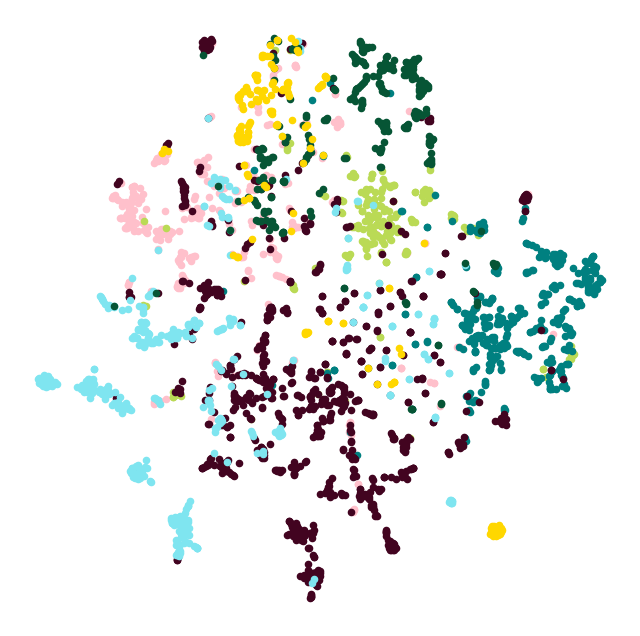

In [62]:
# after your model is learned, run the following scripts and see what you get!
@torch.no_grad()
def plot_points(colors):
    node2vec_model.eval()
    z = node2vec_model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

# Application of GRL: Semi-supervised document classification
As mentioned previously, `Cora` contains 2K documents of scientific papers. However, **only 5% of documents are given the ground-truth labels** in the training set while the remaining documents are unlabeled.

Since each paper(node) is described by a 1433-dimensional bag-of-words feature vector, let's first build a document classifier and see how it works!

In [63]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        return x

In [64]:
model = MLP(hidden_channels=64)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  
    out = model(data.x)  
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  
    optimizer.step() 
    return loss

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9480
Epoch: 002, Loss: 1.9403
Epoch: 003, Loss: 1.9278
Epoch: 004, Loss: 1.9117
Epoch: 005, Loss: 1.8924
Epoch: 006, Loss: 1.8694
Epoch: 007, Loss: 1.8424
Epoch: 008, Loss: 1.8110
Epoch: 009, Loss: 1.7752
Epoch: 010, Loss: 1.7350
Epoch: 011, Loss: 1.6904
Epoch: 012, Loss: 1.6415
Epoch: 013, Loss: 1.5883
Epoch: 014, Loss: 1.5310
Epoch: 015, Loss: 1.4700
Epoch: 016, Loss: 1.4055
Epoch: 017, Loss: 1.3381
Epoch: 018, Loss: 1.2683
Epoch: 019, Loss: 1.1968
Epoch: 020, Loss: 1.1242
Epoch: 021, Loss: 1.0514
Epoch: 022, Loss: 0.9792
Epoch: 023, Loss: 0.9084
Epoch: 024, Loss: 0.8397
Epoch: 025, Loss: 0.7740
Epoch: 026, Loss: 0.7119
Epoch: 027, Loss: 0.6537
Epoch: 028, Loss: 0.5999
Epoch: 029, Loss: 0.5505
Epoch: 030, Loss: 0.5058
Epoch: 031, Loss: 0.4655
Epoch: 032, Loss: 0.4295
Epoch: 033, Loss: 0.3975
Epoch: 034, Loss: 0.3693
Epoch: 035, Loss: 0.3446
Epoch: 036, Loss: 0.3229
Epoch: 037, Loss: 0.3039
Epoch: 038, Loss: 0.2874
Epoch: 039, Loss: 0.2730
Epoch: 040, Loss: 0.2603


In [68]:
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5990


## Improving document classification with node embedding
It seems that the MLP model with the Bag-of-Word feature cannot perform well in the semi-supervised scenario.<br>
Can we make use of the graph structure between documents and generate additional features in unsupervised fashion where the unlabeled document could provide some signals for us.

In [69]:
# Here we use a simple Logistic regression classifier for document classification
from sklearn.linear_model import LogisticRegression

In [72]:
with torch.no_grad():
    node2vec_model.eval()
    # the node embedding is actually the document embedding learned from graph structure
    node_embedding = node2vec_model().cpu().numpy() 
    print(node_embedding.shape)

(2708, 128)


In [74]:
# Training
clf = LogisticRegression() # create logistic regression model
clf.fit(node_embedding[data.train_mask,:], data.y[data.train_mask]) # fit on training set
# Testing
test_acc = clf.score(node_embedding[data.test_mask,:], data.y[data.test_mask])
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7110


Wow! We improve the testing accuracy from ~60%(BOW+MLP) to 70% with network embedding(without using the BOW features) !


Can we further improve the performance by considering both **network structure and BOW features simultaneously?**

In [91]:
# training data
train_bow = data.x[data.train_mask].numpy()
# print(train_bow)
# print(len(train_bow))
train_node_embedding = node_embedding[data.train_mask,:]
# print(train_node_embedding)
# print(len(train_node_embedding))
train_features = np.hstack([train_bow,train_node_embedding])
# print(len(train_features[0]))
# print(len(train_features[1]))
# testing data
test_bow = data.x[data.test_mask].numpy()
test_node_embedding = node_embedding[data.test_mask,:]
test_features = np.hstack([test_bow,test_node_embedding])

print("Training feature:",train_features.shape)
print("Testing feature:",test_features.shape)


Training feature: (140, 1561)
Testing feature: (1000, 1561)


In [93]:
# Training
clf = LogisticRegression() # create logistic regression model
clf.fit(train_features, data.y[data.train_mask]) # fit on training set

# Testing
test_acc = clf.score(test_features, data.y[data.test_mask])
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7110


Not looking good...

Don't worry! We will introduce how the state-of-the-art solution: **Graph Neural Network(GNN)** solves this issue in the following topic.

# Application\#2: Citation recommendation (link prediction)

In the citation prediction problem, we are given the citation graph where documents connect with each other if one cites another. <br>
The goal in to recommend pontential citatations for specific papers. In other words, we're try to find a missing link between documents. <br>
This problem is also a famous task in graph mining called "link prediction" as people would like to know the potential links between nodes.<br>

In [94]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=True),
])
dataset = Planetoid(path, name='Cora', transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]

In [103]:
print(train_data)
print(val_data)
print(test_data)
print(device)
print(transform)
print(len(dataset[0]))

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976])
Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[526], edge_label_index=[2, 526])
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
cuda
Compose([
  NormalizeFeatures(),
  RandomLinkSplit(num_val=0.05, num_test=0.1)
])
3


In [100]:
print("--------Training data------")
print(train_data)
print("Training edges:")
print(train_data.edge_label_index)
print("Labels")
print(train_data.edge_label)

print()

print("--------Validation data------")
print(val_data)
print("Validation edges:")
print(val_data.edge_label_index)
print("Labels")
print(val_data.edge_label[:10])

print()
print("--------Testing data------")
print(test_data)
print("Testing edges:")
print(test_data.edge_label_index)
print("Labels")
print(test_data.edge_label)

--------Training data------
Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976])
Training edges:
tensor([[ 863,  622,   88,  ..., 2521, 2411,  821],
        [1160, 1002, 1713,  ...,  687,  416,  850]])
Labels
tensor([1., 1., 1.,  ..., 0., 0., 0.])

--------Validation data------
Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[526], edge_label_index=[2, 526])
Validation edges:
tensor([[1007,  416, 1376,  ..., 2632,   82, 1319],
        [1154,  519, 2232,  ..., 1508,  907, 2267]])
Labels
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

--------Testing data------
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Testing edges:
tensor([[ 482,  185,  431,  ..., 2147, 2575, 1859],
        [2308, 2003, 2694,  ..., 2387,  

In [104]:
print(train_data.edge_label_index)

tensor([[ 863,  622,   88,  ..., 2521, 2411,  821],
        [1160, 1002, 1713,  ...,  687,  416,  850]])


In [105]:
print(train_data.edge_label)

tensor([1., 1., 1.,  ..., 0., 0., 0.])


## Obtain node embedding with training edges

In [106]:
# Create node2vec model to obtain node embeddings
# Note: We only use the edges in training data (since we're predicting the remaining edges)
node2vec_model = Node2Vec(train_data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = node2vec_model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec_model.parameters()), lr=0.01)

In [107]:
def train():
    node2vec_model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = node2vec_model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [108]:
for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01, Loss: 7.9676


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02, Loss: 5.9450


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03, Loss: 4.8811


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.0909


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 05, Loss: 3.4596


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 06, Loss: 2.9654


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 07, Loss: 2.5495


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 08, Loss: 2.2286


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.9581


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.7485


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.5717


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 12, Loss: 1.4331


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 13, Loss: 1.3228


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 14, Loss: 1.2307


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 15, Loss: 1.1622


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 16, Loss: 1.1020


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 17, Loss: 1.0581


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 18, Loss: 1.0198


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.9899


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.9654


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.9456


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.9281


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.9141


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.9017


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.8917


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.8819


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.8748


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.8699


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.8631


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.8573


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.8536


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.8489


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.8457


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.8430


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.8395


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.8381


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.8342


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.8314


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.8309


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.8294


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.8278


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.8256


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.8250


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.8238


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.8226


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.8208


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.8195


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.8184


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.8180


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.8174


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.8168


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.8157


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.8143


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.8148


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.8142


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.8132


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.8134


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.8121


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.8116


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.8132


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.8106


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.8107


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.8091


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.8092


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.8096


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.8108


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.8088


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.8096


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.8096


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.8084


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.8085


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.8087


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.8079


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.8073


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.8082


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.8069


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.8080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.8074


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.8075


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.8064


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.8083


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.8077


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.8067


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.8068


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.8070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.8064


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.8081


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.8070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.8065


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.8073


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.8071


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.8064


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.8056


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.8053


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.8051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.8062


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.8057


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.8061


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 100, Loss: 0.8063


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 101, Loss: 0.8058


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 102, Loss: 0.8055


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 103, Loss: 0.8062


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 104, Loss: 0.8055


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 105, Loss: 0.8048


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 106, Loss: 0.8044


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 107, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 108, Loss: 0.8054


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 109, Loss: 0.8058


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 110, Loss: 0.8051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 111, Loss: 0.8046


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 112, Loss: 0.8049


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 113, Loss: 0.8069


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 114, Loss: 0.8060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 115, Loss: 0.8051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 116, Loss: 0.8067


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 117, Loss: 0.8048


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 118, Loss: 0.8048


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 119, Loss: 0.8057


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 120, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 121, Loss: 0.8059


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 122, Loss: 0.8045


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 123, Loss: 0.8042


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 124, Loss: 0.8050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 125, Loss: 0.8045


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 126, Loss: 0.8048


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 127, Loss: 0.8058


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 128, Loss: 0.8043


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 129, Loss: 0.8056


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 130, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 131, Loss: 0.8045


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 132, Loss: 0.8047


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 133, Loss: 0.8060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 134, Loss: 0.8042


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 135, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 136, Loss: 0.8054


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 137, Loss: 0.8056


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 138, Loss: 0.8038


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 139, Loss: 0.8051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 140, Loss: 0.8060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 141, Loss: 0.8048


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 142, Loss: 0.8047


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 143, Loss: 0.8037


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 144, Loss: 0.8047


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 145, Loss: 0.8049


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 146, Loss: 0.8050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 147, Loss: 0.8053


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 148, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 149, Loss: 0.8059


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 150, Loss: 0.8061


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 151, Loss: 0.8058


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 152, Loss: 0.8050


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 153, Loss: 0.8061


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 154, Loss: 0.8057


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 155, Loss: 0.8054


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 156, Loss: 0.8059


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 157, Loss: 0.8046


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 158, Loss: 0.8036


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 159, Loss: 0.8051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 160, Loss: 0.8055


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 161, Loss: 0.8057


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 162, Loss: 0.8051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 163, Loss: 0.8069


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 164, Loss: 0.8065


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 165, Loss: 0.8054


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 166, Loss: 0.8056


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 167, Loss: 0.8059


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 168, Loss: 0.8049


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 169, Loss: 0.8057


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 170, Loss: 0.8043


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 171, Loss: 0.8045


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 172, Loss: 0.8053


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 173, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 174, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 175, Loss: 0.8054


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 176, Loss: 0.8051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 177, Loss: 0.8053


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 178, Loss: 0.8048


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 179, Loss: 0.8047


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 180, Loss: 0.8048


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 181, Loss: 0.8054


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 182, Loss: 0.8047


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 183, Loss: 0.8045


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 184, Loss: 0.8059


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 185, Loss: 0.8042


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 186, Loss: 0.8058


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 187, Loss: 0.8041


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 188, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 189, Loss: 0.8053


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 190, Loss: 0.8052


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 191, Loss: 0.8034


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 192, Loss: 0.8044


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 193, Loss: 0.8063


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 194, Loss: 0.8042


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 195, Loss: 0.8039


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 196, Loss: 0.8053


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 197, Loss: 0.8049


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 198, Loss: 0.8043


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 199, Loss: 0.8055


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 200, Loss: 0.8051


## Use the node embedding as feature to train link prediction model
An interesting issue here is: Node2vec gives us the **"node-level"** features while we need the **"edge-level"** information to determin whether a edge exist or not. <br>
Here's some candidate:
1. Concatenation of node A and node B's embeddings 
2. Elementwise-subtract between node A and node B's embeddings 
3. Elementwise-product between node A and node B's embeddings 

Empirically, people use the third approach which leads to the best performance!

In [110]:
with torch.no_grad():
    node2vec_model.eval()
    node_embedding = node2vec_model().cpu().numpy() 
    print(node_embedding.shape)

(2708, 128)


In [111]:
# obtaining embedding feautre
train_embedding_pair = node_embedding[train_data.edge_label_index.T]
print(train_embedding_pair.shape)

# apply element-wise product to represent the "edge" feature
train_features = train_embedding_pair[:,0,:] * train_embedding_pair[:,1,:]
print(train_features.shape) # we have 8976 examples with 128 dimensional feature

(8976, 2, 128)
(8976, 128)


In [113]:
# use LR as classifier for link prediction
link_clf = LogisticRegression()
link_clf.fit(train_features,train_data.edge_label.numpy())

LogisticRegression()

In [114]:
# feature for predicting testing edges
test_embedding_pair = node_embedding[test_data.edge_label_index.T]
print(test_embedding_pair.shape)

# apply element-wise product to represent the "edge" feature
test_features = test_embedding_pair[:,0,:] * test_embedding_pair[:,1,:]
print(test_features.shape) 

(1054, 2, 128)
(1054, 128)


In [115]:
# calculate link prediction accuracy 
acc = link_clf.score(test_features, test_data.edge_label.numpy())
print(f"Accuracy score:{acc:.4f}")
roc = roc_auc_score(test_data.edge_label.numpy(), link_clf.predict_proba(test_features)[:,1])
print(f"ROC score:{roc:.4f}")

Accuracy score:0.7818
ROC score:0.8699
